# Advanced Lane Lines Project

## Include dependencies

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from glob import glob

%matplotlib inline

Cache object is needed to intermediate results between function calls like distortion coefficients

In [3]:
CACHE = {
    'distortion': {}
}

## Common Helper Functions

In [4]:
def load(path):
    """Load images from filesystem"""
    ipaths = glob(path)
    
    images = []
    for ipath in ipaths:
        images.append(plt.imread(ipath))
    
    return images

def imsave(img, name):
    """Save image to the filesystem for debug purposes"""
    global CONFIG
    fname = '{}/{}.jpg'.format(CONFIG['path-debug'], name)
    cv2.imwrite(fname, img)
    
def draw(img, cmap='gray'):
    """Draw image in the notebook"""
    plt.imshow(img, cmap=cmap)
    plt.show()
    
def imdbg(img, name, cmap='gray'):
    """Draw and save image to the file system"""
    draw(img, cmap)
    imsave(img, name)

## Distortion Methods

In [5]:
def getObjImgPoints(image):
    """Get Object points and image points"""
    global CONFIG
    
    for shape in CONFIG['distortion']['shapes']:
        ret, imgpoints = cv2.findChessboardCorners(image, shape, None)
        if ret:
            break
            
    objpoints = np.zeros((shape[0]*shape[1], 3), np.float32)
    objpoints[:,:2] = np.mgrid[0:shape[0], 0:shape[1]].T.reshape(-1,2)
    
    return objpoints, imgpoints, shape, ret
    
def calculate_distortion_coefficients():
    """Method calculates distortion coefficients and saves it to cache"""
    global CONFIG
    global CACHE
    
    CACHE['distortion']['objpoints'] = []
    CACHE['distortion']['imgpoints'] = []
    
    for image in load(CONFIG['distortion']['path']):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        objpoints, imgpoints, shape, ret = getObjImgPoints(gray)

        if not ret:
            print ('Chessboard was not defined')
            cv2.drawChessboardCorners(image, shape, imgpoints, ret)
            draw(image)
            continue
        
        CACHE['distortion']['objpoints'].append(objpoints)
        CACHE['distortion']['imgpoints'].append(imgpoints)

def load_camera_calibration_metric(image):
    """Calculate calibration metrics"""
    global CACHE

    if 'calibration_metrics' in CACHE['distortion']:
        return CACHE['distortion']['calibration_metrics']

    objpoints = CACHE['distortion']['objpoints']
    imgpoints = CACHE['distortion']['imgpoints']
    shape = (image.shape[1], image.shape[0])
    
    metrics = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    CACHE['distortion']['calibration_metrics'] = metrics
    
    return CACHE['distortion']['calibration_metrics']
    
def undistort(image):
    """Method will run undistortion for the image"""
    ret, mtx, dist, rvecs, tvecs = load_camera_calibration_metric(image)
    
    return cv2.undistort(image, mtx, dist, None, mtx)    

## Image Preprocessing

In [6]:
def simple(image):
    """Simple tresholding"""
    global CONFIG
    
    return thresholding(image, CONFIG['preprocessing']['simple'])
    
def sobelx(image):
    """Performs Sobel X binarisation"""
    global CONFIG
    
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    result = thresholding(scaled_sobel, CONFIG['preprocessing']['sobelx'])
    return result

def sobely(image):
    """Performs Sobel Y binarisation"""
    return image

def thresholding(image, thresh):
    """Run thresholding on image"""

    binary = np.zeros_like(image)
    binary[(image > thresh[0]) & (image <= thresh[1])] = 1
    
    return binary

def combination(image1, image2):
    """Calculate combination of 2 binary images"""
    combined = np.zeros_like(image1)
    combined[(image1 == 1) | (image2 == 1)] = 1
    
    return combined
    
def color_preprocessing(image):
    """
    Color preprocessing run:
        * sobel transform
        * image tresholding
    """
    global CONFIG
    
    # convert to HLS schema
    HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    HLS = HLS.astype(np.float)

    # split layers
    H, L, S = HLS[:,:,0], HLS[:,:,1], HLS[:,:,2]
    
    # init base
    result = np.zeros(image.shape[:2])
    
    # simply threshold S layer
    if 'simple' in CONFIG['preprocessing']:
        result = combination(result, simple(S))
    
    # run sobelx transform on L layer
    if 'sobelx' in CONFIG['preprocessing']:
        result = combination(result, sobelx(L))
    
    return result

### Image warping and area of interests methods

In [7]:
def draw_aoi(image):
    """Method will draw aoi on the image"""
    global CONFIG
    image = image.copy()
    
    aoi = np.array(CONFIG['aoi']['coordinates'])
    color = (0, 0, 255)
    
    image = cv2.polylines(image, [aoi], True, color=color, thickness=2, lineType=cv2.LINE_AA)
    return image

def warp(image, zoom=True):
    """Run warping on the image"""
    global CONFIG
    
    offset = CONFIG['aoi']['warp-offset']
    
    crd1 = CONFIG['aoi']['coordinates']
    crd2 = [
        (crd1[0][0] + offset, crd1[0][1]),
        (crd1[0][0] + offset, 0),
        (crd1[3][0] - offset, 0),
        (crd1[3][0] - offset, crd1[3][1])
    ]
    
    src, dst = (crd1, crd2) if zoom else (crd2, crd1)

    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    result = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))  
    
    return result

## Line detection methods

In [8]:
def define_starting_points(binary_warped):
    """Defines 2 start points for both lines on the road"""
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    return leftx_base, rightx_base
    
def detect_fitx(binary, ploty, start_point, nonzerox, nonzeroy):
    """Run iteration over number of supposed windows and define lines"""
    global CONFIG
    config = CONFIG['ident-lines']['windows']
    
    inds = []
    current = start_point
    w_height = np.int(binary.shape[0]/config['quantity'])
    
    # Step through the windows one by one
    for i in range(config['quantity']):
        
        # Identify window boundaries
        win_y_high = binary.shape[0] - i*w_height
        win_y_low  = win_y_high - w_height
        win_x_high = current + config['margin']
        win_x_low  = current - config['margin']

        _inds = (
            (nonzeroy >= win_y_low) 
            & (nonzeroy < win_y_high) 
            & (nonzerox >= win_x_low) 
            & (nonzerox < win_x_high)
        ).nonzero()[0]

        if len(_inds) > config['minpix']:
            current = np.int(np.mean(nonzerox[_inds]))

        inds.append(_inds)
    
    inds = np.concatenate(inds)

    # Fit a second order polynomial
    fit  = np.polyfit(nonzeroy[inds],  nonzerox[inds],  2)
    
    # Generate x values for plotting
    fit = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    return fit

def detect_lines(binary):
    """Main method that detect both left and right lines"""
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])

    # Current positions to be updated for each window
    left_start, right_start = define_starting_points(binary)

    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )

    left_x = detect_fitx(binary, ploty, left_start, nonzerox, nonzeroy)    
    right_x = detect_fitx(binary, ploty, right_start, nonzerox, nonzeroy)
    
    return ploty, left_x, right_x

def create_color_mask(zoomed, ploty, left_fitx, right_fitx):
    """Create color warped mask"""
    mask = np.zeros_like(zoomed)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(mask, np.int_([pts]), (0, 255, 0))

    return mask

## Main method to draw lines

In [22]:
def process_image(image):
    """Main method to draw lane lines"""
    imdbg(image, 'original')
    
    image = undistort(image)  
    imdbg(image, 'undistored')
    
    # binarise image using different techniques
    binary = color_preprocessing(image)
    imdbg(binary, 'preprocessed')
    
    # show area of interests
    image_aoi = draw_aoi(image)
    imdbg(image_aoi, 'aoi')
    
    # crop and warp area of interests
    zoomed = warp(binary)
    imdbg(zoomed, 'zoomed')

    # find lines
    ploty, left_fitx, right_fitx = detect_lines(zoomed)
    
    # create warped color mask
    mask = create_color_mask(zoomed, ploty, left_fitx, right_fitx)
    imdbg(mask, 'mask')
    # unwarp mask so we will be able to apply it on image.
    unwarped_mask = warp(mask, zoom=False)
    
    draw(warp(zoomed, zoom=False))
#     print (unwarped_mask)
    # remove bottom of the image
#     y = CONFIG['aoi']['coordinates'][0][1]
#     unwarped_mask[:,y:] = (0, 0, 0)
    print (image.shape)
    print (unwarped_mask.shape)
    # apply mask on original undistorted image
    result = cv2.addWeighted(image, 1, unwarped_mask, 0.3, 0)
    imdbg(result, 'result')
    
    return result

## Calculate distortion coefficients

Chessboard was not defined


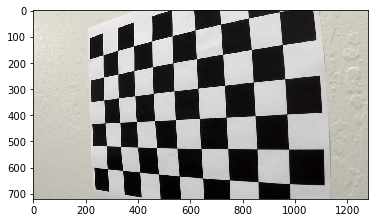

In [23]:
calculate_distortion_coefficients()

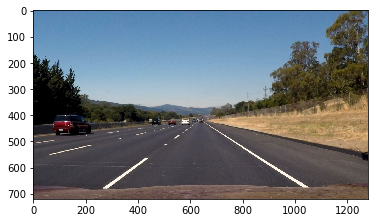

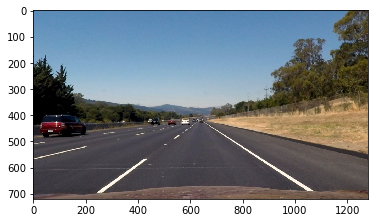

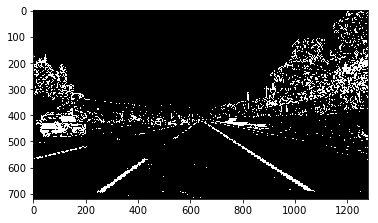

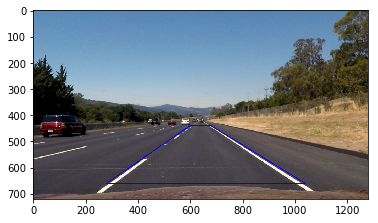

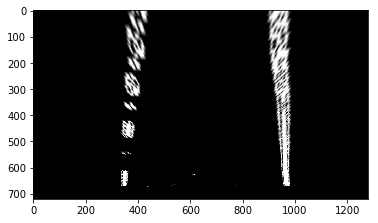

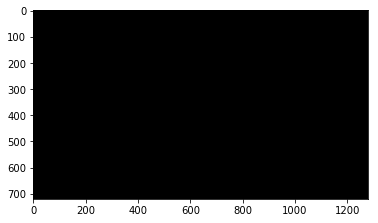

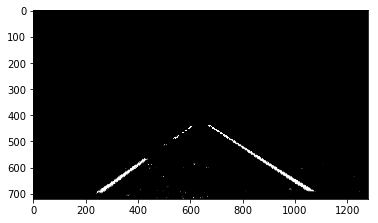

(720, 1280, 3)
(720, 1280)


error: /Users/travis/miniconda3/conda-bld/opencv_1489537407268/work/opencv-3.1.0/modules/core/src/arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


In [24]:
CONFIG = {
    'distortion' : {
        'path': 'camera_cal/*',
       
        # 2 variants cause there is no possibilito to 
        # define corners on some chessboards with 9, 6 shape
        'shapes': [(9, 6), (7, 6), (9, 5)]
    },
    'path-test': 'test_images/*',
    'path-debug': 'debug',
    
    'preprocessing': {
        'simple':  (130, 255),
        'sobelx': (20, 100)
    },
    
    'aoi': {
        'coordinates': [
            (280, 660), (600, 440),
            (680, 440), (1040, 660)
        ],
        'warp-offset': 50
    },
    'ident-lines': {
        'windows': {
            'quantity': 9,
            'margin': 100,
            'minpix': 50
        }
    }

}

images = load(CONFIG['path-test'])
image = process_image(images[1])
draw(image)

## Process video